# ARIMA 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

 arima모델을 활용하여 베이스라인을 제작하였습니다. 본 베이스라인은 대회에 참여함에 있어서, 데이콘이 제공하는 DataFrame을 수정하여 submission를 생성하는 과정에 이르는 일련의 과정을 담고 있습니다. 현재 베이스라인을 참고하여 본인만의 새로운 코드를 작성하여 공유해주시기를 바랍니다. 
 
 감사합니다.

# 1. Library Import

In [4]:
#! pip install pyramid_arima

!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 19.0MB/s 
     |████████████████████████████████| 2.1MB 29.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


# 2. 데이터 불러오기

In [5]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima
import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) read_csv

In [6]:
train_x_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/test_x_df.csv')

In [ ]:
train_x_df.iloc[:,2:].shape[1]

10

## 2) numpy arrary로 변환하기

In [ ]:
# 왜 3차원으로 바꾸는거지? 2차원의 데이터를 이어주기 위해서?
# 행의 갯수가 다르고 코인인덱스를 바꾸던가 이런거 해야함

train_x_df.sample_id.value_counts()

7360    1380
2445    1380
2447    1380
2446    1380
2449    1380
        ... 
4909    1380
4914    1380
4915    1380
4912    1380
0       1380
Name: sample_id, Length: 7362, dtype: int64

In [7]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]  # 모든 행을 가져오고 열은 0과1번째를 제외한 2번째부터
                                              # 가져와서 shape[1]로 열의 갯수를 가져옴 즉, 10
                                              # df, array = shape쓴다
                                              # df, array는 다차원이므로 []로 위치를 나타냄.
                                              # 0이면 행, 1이면 열, 2면 높이
                                              # 즉, shape[1]는 열의 갯수
                                              # list는 length()함수를 써서 길이 계산

    time_size = len(df_2d.time.value_counts()) #time 열의 특성값들의 갯수를 세어 time의 크기가 몇개인지 체크

    sample_size = len(df_2d.sample_id.value_counts()) # sample 열의 특성값 갯수를 세어 sample_id의 크기가 몇인지 체크  


    #value counts는 유니크한 값들을 주기때문에 그것의 갯수를 구하려면 len() 써야함

    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size]) #2차원의 df를 3차원 numpy array로 reshape해주는데
                                                                                       #크기를 (sample size, time size, feature size)로 해주는것
                                                                                       # sample size가 행 갯수, time size가 열의 갯수, feature size가 3차원쪽 갯수를 세어 sample_id의 크기가 몇인지 체크  
                                                                                                                                                                                           
                                #위의 values는 칼럼이름 필요없고 그냥 값들만 불러오는것
                                #values하면 df가 array가 되는 것
                                # ~~.~~.~~. 은 ~~하고 ~~ 한다 이런 느낌                               
                                                                

    return array_3d


    # 교수님 설명
    # x는 몇차 y는 몇차 z는 몇차 즉, 차원을 정해줘야함
    # 

In [8]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [9]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



## 3) 샘플 확인하기

In [ ]:
idx=1024
np.arange(len(train_x_array[idx,:,1]), len(train_x_array[idx,:,1])+len(train_y_array[idx,:,1]))

array([1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390,
       1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401,
       1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412,
       1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423,
       1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434,
       1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445,
       1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456,
       1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467,
       1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478,
       1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489,
       1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499])

In [10]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series') # ?!?!
    plt.axhline(1, c = 'red')
    plt.legend()

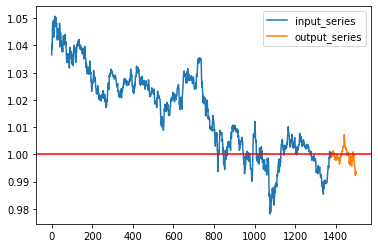

In [11]:
# sample_id 100에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 100
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 3. 모델 훈련하기

In [ ]:
#https://byeongkijeong.github.io/ARIMA-with-Python/

# ARIMA pdq 참고할것

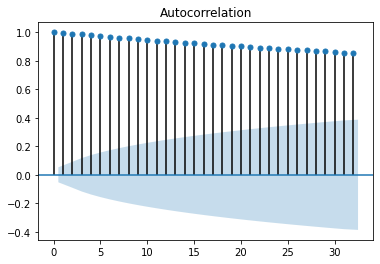

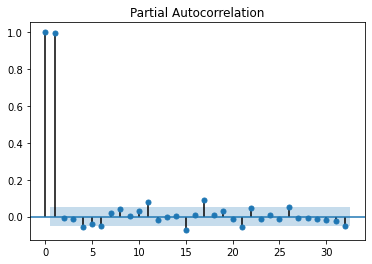

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(x_series)
plot_pacf(x_series)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=x_series.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

AttributeError: ignored

## 1) train 샘플 훈련하기

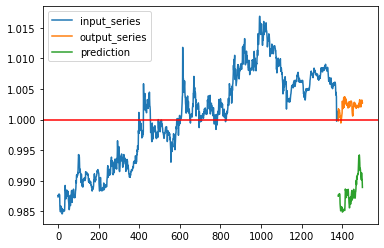

In [ ]:
idx = 1021
# train data 중 sample_id 1021에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

model = ARIMA(x_series, order=(3,0,100))  #(3,0,1) Y(t) = B(1)Y(t-1) + B(2)Y(t-2) + B(3)Y(t-3) + B(4)E(1) + E
fit  = model.fit()
preds = fit.predict(1,120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()


# 새 섹션

###잠깐 내혼자 해봄

In [ ]:
idx=range(7361)
#len(idx)
idx
#len(train_x_array)

range(0, 7361)

In [ ]:
#pmd arima needed to use on colab!

idx=range(7362)
for i in (idx):
  # train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
  # y_sereis를 추론
  x_series = train_x_array[idx,:,1]
  y_series = train_y_array[idx,:,1]

  # ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
  model = ARIMA(x_series, order=(3,0,1)) 
  fit  = model.fit()
  preds = fit.predict(1,120, typ='levels')


ValueError: ignored

In [ ]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

In [ ]:
idx = 1023
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

In [ ]:
start_time = '2021-01-31 00:00:00'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [ ]:
x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()

In [ ]:
x_df

,ds,y
0,2021-01-31 00:01:00,0.973584
1,2021-01-31 00:02:00,0.979305
2,2021-01-31 00:03:00,0.978507
3,2021-01-31 00:04:00,0.974601
4,2021-01-31 00:05:00,0.978064
...,...,...
1375,2021-01-31 22:56:00,1.001131
1376,2021-01-31 22:57:00,1.005248
1377,2021-01-31 22:58:00,1.005039
1378,2021-01-31 22:59:00,0.997208


In [ ]:
from pmdarima.arima import ADFTest
model = auto_arima(x_df,star_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5,start_P=0,D=1,star_Q=0, max_P=5,max_D=5,max_Q=5,m=12,seasonal=False, error_action='warn',trace=True,supress_warnings=True, stepwise=True,random_state=30, n_fits=50)

TypeError: ignored

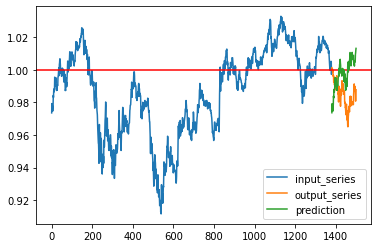

In [ ]:
idx = 1023
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

model = ARIMA(x_series, order=(1,0,3)) 
fit  = model.fit()
preds = fit.predict(1,120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()


## 2) validation set 훈련하기

### <1> validation 데이터 생성하기

In [ ]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([500, 120])

### <2> 학습 및 추론하기

In [ ]:
# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

100%|██████████| 500/500 [07:49<00:00,  1.06it/s]


### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [ ]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [ ]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [ ]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,0,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
495,495,0,6
496,496,0,116
497,497,0,2
498,498,0,90


In [ ]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    497
1      3
Name: buy_quantity, dtype: int64

### <4> 투자 후 금액 계산하기

In [ ]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [ ]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [ ]:
# 투자 후 금액
print(total_momey)

9948.49894603496


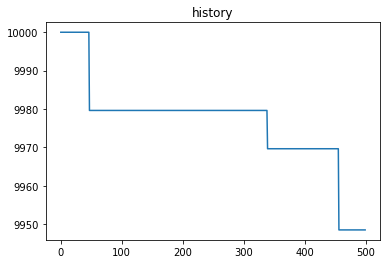

In [ ]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]
            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [07:06<00:00,  1.24it/s]


## 추론한 test_pred_array를 바탕으로 submission df 생성하기

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)

In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/비트코인 예측/baseline_modified_submission_v2.csv', index = False)

# 내마음대로

In [ ]:
train_x_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/Dacon/비트코인 예측/data/test_x_df.csv')

In [ ]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10159555,7361,1375,8,1.000668,1.001669,1.000626,1.001502,9.180907e+00,2203.059082,2.245034,6.229020e+00,1494.727417
10159556,7361,1376,8,1.001627,1.001920,1.000960,1.001294,7.963097e+00,1911.151611,2.211651,3.056139e+00,733.490601
10159557,7361,1377,8,1.001294,1.001461,1.000584,1.000668,3.849893e+00,923.610718,1.260224,2.284546e+00,548.042297
10159558,7361,1378,8,1.000709,1.000751,1.000042,1.000042,1.337402e+00,320.624756,0.826239,5.164965e-01,123.819839


In [ ]:
#train_x_sp=train_x_df['coin_index'].unique().tolist()
#print(train_x_sp)

df_0=train_x_df.loc[train_x_df['coin_index']==0]
df_0

df_1=train_x_df.loc[train_x_df['coin_index']==1]
df_1

df_2=train_x_df.loc[train_x_df['coin_index']==2]
df_2

df_3=train_x_df.loc[train_x_df['coin_index']==3]
df_3

df_4=train_x_df.loc[train_x_df['coin_index']==4]
df_4

df_5=train_x_df.loc[train_x_df['coin_index']==5]
df_5

df_6=train_x_df.loc[train_x_df['coin_index']==6]
df_6

df_7=train_x_df.loc[train_x_df['coin_index']==7]
df_7

df_8=train_x_df.loc[train_x_df['coin_index']==8]
df_8

df_9=train_x_df.loc[train_x_df['coin_index']==9]
df_9

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
5520,4,0,9,0.954524,0.954567,0.953652,0.953813,0.008043,61.934696,0.033946,0.000877,6.754054
5521,4,1,9,0.953924,0.953984,0.953587,0.953774,0.002639,20.318293,0.028495,0.001553,11.953619
5522,4,2,9,0.953819,0.953948,0.953695,0.953708,0.002875,22.132622,0.025521,0.001508,11.606707
5523,4,3,9,0.953705,0.954815,0.953696,0.954757,0.017611,135.619019,0.048689,0.015704,120.929970
5524,4,4,9,0.954756,0.955166,0.953829,0.953994,0.007501,57.793373,0.049308,0.003829,29.496428
...,...,...,...,...,...,...,...,...,...,...,...,...
10155415,7358,1375,9,1.001846,1.001881,1.001453,1.001580,0.001128,12.122380,0.021808,0.000251,2.696240
10155416,7358,1376,9,1.001580,1.001580,1.001085,1.001141,0.003166,34.022411,0.042776,0.001630,17.517410
10155417,7358,1377,9,1.001140,1.001142,0.999795,1.000072,0.006166,66.179955,0.094593,0.001502,16.119551
10155418,7358,1378,9,1.000080,1.000382,0.999779,1.000001,0.002055,22.057827,0.049580,0.001138,12.212457


In [ ]:
df_9x = df_9
df_9x = df_9x.drop(['low','high','close'], axis=1)
df_9x

,sample_id,time,coin_index,open,volume,quote_av,trades,tb_base_av,tb_quote_av
5520,4,0,9,0.954524,0.008043,61.934696,0.033946,0.000877,6.754054
5521,4,1,9,0.953924,0.002639,20.318293,0.028495,0.001553,11.953619
5522,4,2,9,0.953819,0.002875,22.132622,0.025521,0.001508,11.606707
5523,4,3,9,0.953705,0.017611,135.619019,0.048689,0.015704,120.929970
5524,4,4,9,0.954756,0.007501,57.793373,0.049308,0.003829,29.496428
...,...,...,...,...,...,...,...,...,...
10155415,7358,1375,9,1.001846,0.001128,12.122380,0.021808,0.000251,2.696240
10155416,7358,1376,9,1.001580,0.003166,34.022411,0.042776,0.001630,17.517410
10155417,7358,1377,9,1.001140,0.006166,66.179955,0.094593,0.001502,16.119551
10155418,7358,1378,9,1.000080,0.002055,22.057827,0.049580,0.001138,12.212457


In [ ]:
#def coin(x):
  #for i in len()
train_x_df['coin_index'].unique


<bound method Series.unique of 0           7
1           7
2           7
3           7
4           7
           ..
10159555    8
10159556    8
10159557    8
10159558    8
10159559    8
Name: coin_index, Length: 10159560, dtype: int64>

In [ ]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.000392,1.000588,1.000392,1.000588,8.305119e+05,42356.179688,137.308746,8.305119e+05,42356.179688
1,0,1,7,1.000588,1.001177,1.000392,1.001177,5.320066e+05,27140.638672,294.233032,4.882738e+05,24909.861328
2,0,2,7,1.001177,1.001177,1.001177,1.001177,5.113770e+05,26100.681641,58.846603,5.113770e+05,26100.681641
3,0,3,7,1.001177,1.001373,1.001177,1.001373,1.134853e+06,57929.410156,137.308746,1.095514e+06,55921.156250
4,0,4,7,1.000981,1.000981,0.999804,1.000196,5.801173e+06,295872.343750,666.928162,9.911239e+05,50528.589844
...,...,...,...,...,...,...,...,...,...,...,...,...
883435,7361,115,8,1.007303,1.007845,1.007261,1.007720,2.843995e+00,686.734558,0.792856,1.373841e+00,331.730499
883436,7361,116,8,1.007678,1.008847,1.007678,1.008471,2.577599e+00,622.798462,0.884660,1.638966e+00,396.005463
883437,7361,117,8,1.008513,1.009014,1.008304,1.008805,4.579865e+00,1106.928345,1.210149,1.735705e+00,419.485596
883438,7361,118,8,1.008680,1.009222,1.008680,1.009222,1.065129e+00,257.542755,0.525789,4.348240e-01,105.134232


In [ ]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

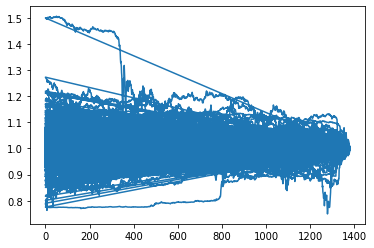

In [ ]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
#idx = 1045
plt.plot(df_9['time'], df_9['open'])
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

ValueError: ignored

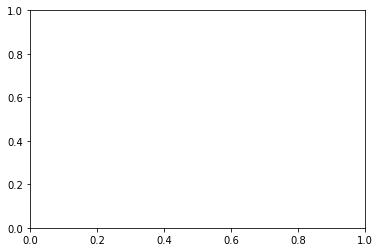

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_x_df)
plot_pacf(train_x_df)
plt.show()

In [ ]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
xx_df = train_x_df
yy_df = train_y_df

xx_array = df2d_to_array3d(xx_df)
yy_array = df2d_to_array3d(yy_df)
valid_pred_array = np.zeros([500, 120])

In [ ]:
# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(xx_array.shape[0])):
    try:
        try:
            x_series = xx_array[idx,:,1]

            model = ARIMA(x_series, order=(1,0,3))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = xx_array[idx,:,1]

            model = ARIMA(x_series, order=(0,1,2))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

  3%|▎         | 237/7362 [05:18<1:51:44,  1.06it/s]

order 4 1 1


  3%|▎         | 238/7362 [05:19<1:53:53,  1.04it/s]

order 4 1 1


  3%|▎         | 239/7362 [05:19<1:48:40,  1.09it/s]

238  샘플은 수렴하지 않습니다.


  3%|▎         | 242/7362 [05:26<3:03:05,  1.54s/it]